In [1]:
from utils.imports import *

In [2]:
from utils.start_spark import spark
! start http://localhost:4040/jobs/

In [3]:
%%capture 
from files.dfs import *
readAllCsvs(spark, infer = False)

# Cleanup

In [4]:
cleaned_up = train.df

Ao fazer uma pesquisa adicional sobre esta base de dados pudemos observar [várias inconsistências nela](https://www.kaggle.com/code/abaojiang/eda-on-game-progress), como número de checkpoints não adequados, saltos de `index`es fora de checkpoints, e *primary keys* duplciadas.

## `elapsed_time`

In [5]:
elapsedTimes = train.df.groupby("session_id") \
    .agg(max(col("elapsed_time")).alias("max_elipsed_time")) \
    .withColumn("total_hours", round(col("max_elipsed_time")/3.6e6, 5)) \
    .toPandas()

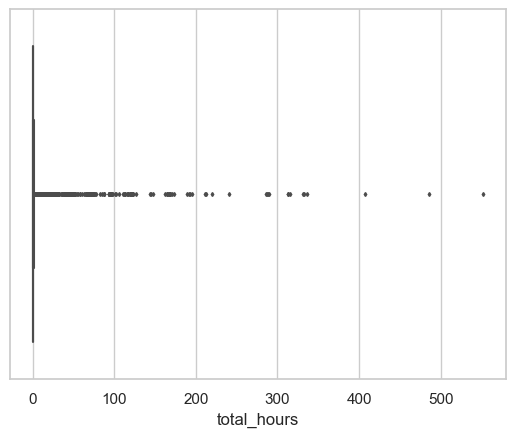

In [6]:
sns.set_theme(style="whitegrid")
temp = sns.boxplot(x = elapsedTimes["total_hours"], fliersize = 2)

<Axes: xlabel='total_hours', ylabel='Count'>

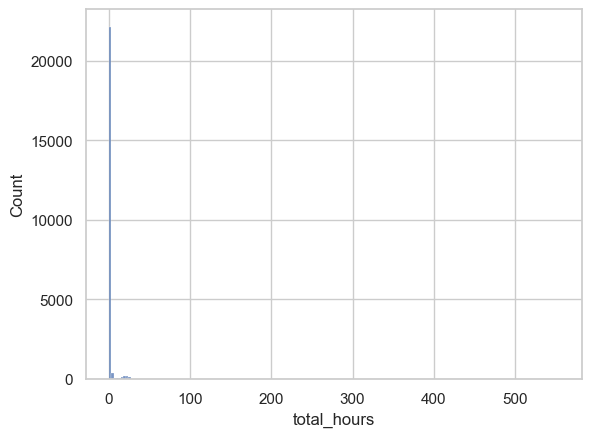

In [7]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

<Axes: xlabel='total_hours', ylabel='Count'>

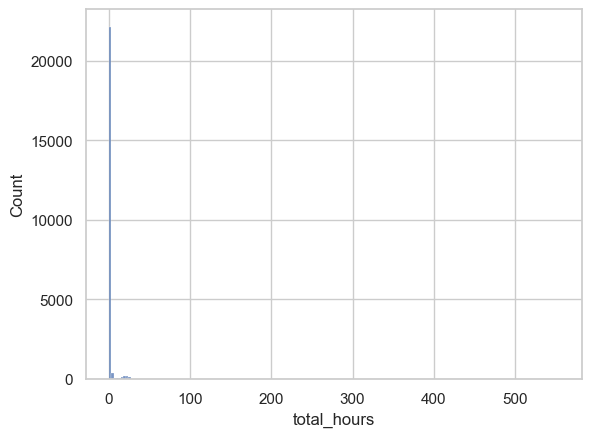

In [8]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

## `checkpoint`

In [9]:
sessions_to_rem = train.df.filter(col("event_name") == "checkpoint") \
    .groupBy("session_id") \
    .count() \
    .filter(col("count") != 3).cache()
sessions_to_rem.limit(10)

session_id,count
21000508045881390,4
21070307465436760,4
21000416114287984,4
22050515531938264,6
22090409201202380,6
21050214304037116,5
21090110004071096,5
22030506384795480,5
21100309321472060,4
22030410154791324,5


In [10]:
cleaned_up = cleaned_up.filter(~col("session_id").isin([i.session_id for i in sessions_to_rem.collect()]))

In [11]:
cleaned_up.write.mode("overwrite").parquet("df_cleaned_up")

# Transformação

In [12]:
splited = train_labels.df \
    .select(
        split("session_id", "_").alias("both"),
        "correct"
    ).select(
        col("both")[0].alias("session_id"),
        col("both")[1].alias("question"),
        col("correct").alias("isCorrect")
    ).cache()
splited.groupby("session_id").count().sort(col("count").asc()).limit(3)

session_id,count
20100209442654932,18
20100216323445964,18
20100308255503228,18


In [13]:
(pivoted := splited.groupby("session_id").pivot("question").agg(first("isCorrect"))).cache()
pivoted.limit(5)

session_id,q1,q10,q11,q12,q13,q14,q15,q16,q17,q18,q2,q3,q4,q5,q6,q7,q8,q9
20110512573169570,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20100216323445964,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1
21020308080777748,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0
21040512382351228,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0
22030108542877704,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0


Uma forma de transformar a target é, em vês da planeada "dataframe de sessões", teriamos uma "dataframe de perguntas", onde em vês de estar uma dataframe com cada linah uma sessão, estar 18 das mesmas linhas, com a diferença nas questões. Ou seja, a nossa chave primária seria o conjunto da das colunas `session_id` e `question` (categórica ou inteira), em vês de apenas ter como chave primária `session_id`.

| session_id | q1 | q2 | ... | q18 | feature1 | feature2 | ... |
|------------|----|----|-----|-----|----------|----------|-----|
| 1          | 0  | 1  | ... | 1   | 423      | 0        | ... |
| 2          | 1  | 0  | ... | 1   | 231      | 1        | ... |
| 3          | 1  | 1  | ... | 1   | 345      | 1        | ... |

para

| session_id | question | answer | feature1 | feature2 | ... |
|------------|----------|--------|----------|----------|-----|
| 1          | 1        | 0      | 423      | 0        | ... |
| 1          | 2        | 1      | 423      | 0        | ... |
| ...        | ...      | ...    | ...      | ...      | ... |
| 1          | 18       | 1      | 423      | 0        | ... |
| 2          | 1        | 1      | 231      | 1        |     |
| ...        | ...      | ...    | ...      | ...      | ... |

Esta opção iria facilitar o processo de previsão, pois podemos usar métodos simples como regressão logística, usando `question` como uma feature também.

Uma segunda opção seria usar classificação *multi-label*, sendo que temos vários `targets`, mas estes só têm uma carnidalidade de 2. Isto iria aumentar a complexidade do projeto. Estamos também limitados pela utilização de MLLIB do spark.

A terceira opção seria treinar 18 modelos, e criar um algoritmo para escolher um modelos na precisão. Essencialmente, este é o método de `binary relevance`, sendo um dos métodos da segunda opção; no entanto, estamos a notar como opção porque não parece que o MLLIB tenha qualquer opção de `binary relevance`.

Nota: da forma como os dados estão agora formatados, essencialmente é o mesmo problema se tivéssemos em vês de uma matriz de 0s e 1s, uma coluna com um array das classes onde a sessão teve certo. 

In [14]:
cleaned_up.limit(1) #TODO remove

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,null,null,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,null,null,null,0-4


In [15]:
# Amostra
sessions_to_get = train.df.select("session_id").distinct().sample(fraction=0.2, seed=1)
amostra = train.df.filter(col("session_id").isin("sessions_to_get"))

In [25]:
if 'stages' in sys.modules: del sys.modules['stages']
from stages import *

pipeline = Pipeline(stages = [
    the_transformer(
        add_id,
        elapsed_to_diff,
        # (elapsed_to_diff_per_group, spark),
        # (stages.negative_to_0, "diff_elapsed_per_event_ms"),
        (elapsed_to_hours, "elapsed_time", "elapsed_time_h"),
        agg1
    ), MinMaxScaler(inputCol = "inv_total_time_h", outputCol = "normalized_total_time_h")
])
pipeline_fitted = pipeline.fit(amostra)
(transformed := pipeline_fitted.transform(amostra)).cache()
transformed.orderBy("session_id")

In [25]:
if 'stages' in sys.modules: del sys.modules['stages']
from stages import *

pipeline = Pipeline(stages = [
    the_transformer(
        add_id,
        elapsed_to_diff,
        # (elapsed_to_diff_per_group, spark),
        # (stages.negative_to_0, "diff_elapsed_per_event_ms"),
        (elapsed_to_hours, "elapsed_time", "elapsed_time_h"),
        agg1
    ), MinMaxScaler(inputCol = "inv_total_time_h", outputCol = "normalized_total_time_h")
])
pipeline_fitted = pipeline.fit(amostra)
(transformed := pipeline_fitted.transform(amostra)).cache()
transformed.orderBy("session_id")